# Train

In [1]:
import os
import sys
import html
import tarfile
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import time

PROJECT_PATH = '/kaggle/working/phase_safe'
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
DATA_SAVE_PATH = os.path.join(PROJECT_PATH, 'data')

if not os.path.exists(CHECKPOINT_PATH): os.makedirs(CHECKPOINT_PATH)
if not os.path.exists(DATA_SAVE_PATH): os.makedirs(DATA_SAVE_PATH)

print(f"Safe Mode Setup Complete. Dir: {PROJECT_PATH}")

!pip install -q tokenizers sacrebleu torchtext

Safe Mode Setup Complete. Dir: /kaggle/working/phase_safe
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.9 MB/s eta 0:00:00a 0:00:01


In [2]:
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import TemplateProcessing
from torch.utils.data import Dataset, DataLoader

def prepare_data():
    data_dir = os.path.join(PROJECT_PATH, 'raw_data')
    if not os.path.exists(data_dir): os.makedirs(data_dir)
    tgz_path = os.path.join(data_dir, "train-en-vi.tgz")
    
    if not os.path.exists(os.path.join(data_dir, "train.vi")):
        print("Downloading data...")
        os.system(f"wget -q https://github.com/stefan-it/nmt-en-vi/raw/master/data/train-en-vi.tgz -O {tgz_path}")
        with tarfile.open(tgz_path, "r:gz") as tar:
            tar.extractall(path=data_dir)
            
    clean_paths = {}
    for lang in ['vi', 'en']:
        raw_path = os.path.join(data_dir, f"train.{lang}")
        clean_path = os.path.join(DATA_SAVE_PATH, f"clean_train.{lang}")
        if not os.path.exists(clean_path):
            with open(raw_path, 'r', encoding='utf-8') as f_in, open(clean_path, 'w', encoding='utf-8') as f_out:
                for line in f_in:
                    clean_line = html.unescape(line).replace('\xa0', ' ').strip()
                    if clean_line:
                        f_out.write(clean_line + "\n")
        clean_paths[lang] = clean_path
    return clean_paths['vi'], clean_paths['en']

clean_vi, clean_en = prepare_data()

def get_tokenizer(files, name):
    vocab_file = os.path.join(DATA_SAVE_PATH, f"{name}-vocab.json")
    merges_file = os.path.join(DATA_SAVE_PATH, f"{name}-merges.txt")
    if os.path.exists(vocab_file):
        tok = ByteLevelBPETokenizer(vocab_file, merges_file)
    else:
        print(f"Training tokenizer: {name}...")
        tok = ByteLevelBPETokenizer()
        # Giảm vocab size xuống 8000 để mô hình tập trung hơn (Safe choice)
        tok.train(files=files, vocab_size=8000, min_frequency=2, special_tokens=["<pad>", "<sos>", "<eos>", "<unk>"])
        tok.save_model(DATA_SAVE_PATH, name)
    return tok

src_tokenizer = get_tokenizer([clean_vi], "src_bpe")
trg_tokenizer = get_tokenizer([clean_en], "trg_bpe")

for tok in [src_tokenizer, trg_tokenizer]:
    tok.post_processor = TemplateProcessing(
        single="<sos> $A <eos>",
        special_tokens=[("<sos>", 1), ("<eos>", 2)],
    )
    tok.enable_padding(pad_id=0, pad_token="<pad>")

class BPEDataset(Dataset):
    def __init__(self, src_file, trg_file, src_tok, trg_tok, max_len=128): # Giảm max_len chút cho nhẹ
        self.src_data = []
        self.trg_data = []
        self.src_tok = src_tok
        self.trg_tok = trg_tok
        self.max_len = max_len
        with open(src_file, 'r', encoding='utf-8') as f: src_lines = f.readlines()
        with open(trg_file, 'r', encoding='utf-8') as f: trg_lines = f.readlines()
        for s, t in zip(src_lines, trg_lines):
            self.src_data.append(s.strip())
            self.trg_data.append(t.strip())

    def __len__(self): return len(self.src_data)

    def __getitem__(self, index):
        src_ids = self.src_tok.encode(self.src_data[index]).ids
        trg_ids = self.trg_tok.encode(self.trg_data[index]).ids
        if len(src_ids) > self.max_len: src_ids = src_ids[:self.max_len]
        if len(trg_ids) > self.max_len: trg_ids = trg_ids[:self.max_len]
        return torch.tensor(src_ids), torch.tensor(trg_ids)

def collate_fn(batch):
    src_batch, trg_batch = [], []
    for s, t in batch:
        src_batch.append(s)
        trg_batch.append(t)
    src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, padding_value=0, batch_first=True)
    trg_batch = torch.nn.utils.rnn.pad_sequence(trg_batch, padding_value=0, batch_first=True)
    return src_batch, trg_batch

train_dataset = BPEDataset(clean_vi, clean_en, src_tokenizer, trg_tokenizer)
train_iterator = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=2)

/tmp/ipykernel_55/3175411450.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=data_dir)


Training tokenizer: src_bpe...



Training tokenizer: trg_bpe...





In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x): return x + self.pe[:, :x.size(1)]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        self.d_head = d_model // n_head
        self.n_head = n_head
        self.d_model = d_model
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)
    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        Q = self.w_q(query).view(batch_size, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        K = self.w_k(key).view(batch_size, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        V = self.w_v(value).view(batch_size, -1, self.n_head, self.d_head).permute(0, 2, 1, 3)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / math.sqrt(self.d_head)
        if mask is not None: energy = energy.masked_fill(mask == 0, -1e9)
        attention = torch.softmax(energy, dim=-1)
        x = torch.matmul(attention, V)
        x = x.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        return self.fc_out(x)

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
    def forward(self, x): return self.fc2(self.relu(self.fc1(x)))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_head)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, src, mask):
        _src = self.attn(src, src, src, mask)
        src = self.norm1(src + self.dropout(_src))
        _src = self.ffn(src)
        src = self.norm2(src + self.dropout(_src))
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_head, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_head)
        self.cross_attn = MultiHeadAttention(d_model, n_head)
        self.ffn = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, trg, enc_src, trg_mask, src_mask):
        _trg = self.self_attn(trg, trg, trg, trg_mask)
        trg = self.norm1(trg + self.dropout(_trg))
        _trg = self.cross_attn(trg, enc_src, enc_src, src_mask)
        trg = self.norm2(trg + self.dropout(_trg))
        _trg = self.ffn(trg)
        trg = self.norm3(trg + self.dropout(_trg))
        return trg

class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, n_head, n_layer, d_ff, dropout, max_len, pad_idx):
        super().__init__()
        self.src_pad_idx = pad_idx
        self.trg_pad_idx = pad_idx
        self.encoder_emb = nn.Embedding(src_vocab, d_model)
        self.decoder_emb = nn.Embedding(trg_vocab, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, n_head, d_ff, dropout) for _ in range(n_layer)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, n_head, d_ff, dropout) for _ in range(n_layer)])
        self.fc_out = nn.Linear(d_model, trg_vocab)
        self.dropout = nn.Dropout(dropout)

    def make_src_mask(self, src):
        return (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

    def make_trg_mask(self, trg):
        pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        sub_mask = torch.tril(torch.ones((trg.shape[1], trg.shape[1]), device=trg.device)).bool()
        return pad_mask & sub_mask

    def encode(self, src, src_mask):
        src = self.dropout(self.pos_enc(self.encoder_emb(src)))
        for layer in self.encoder_layers: src = layer(src, src_mask)
        return src

    def decode(self, trg, enc_src, trg_mask, src_mask):
        trg = self.dropout(self.pos_enc(self.decoder_emb(trg)))
        for layer in self.decoder_layers: trg = layer(trg, enc_src, trg_mask, src_mask)
        return self.fc_out(trg)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encode(src, src_mask)
        output = self.decode(trg, enc_src, trg_mask, src_mask)
        return output

In [4]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, padding_idx, smoothing=0.1, dim=-1):
        super().__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.padding_idx = padding_idx
        self.dim = dim
    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            true_dist[:, self.padding_idx] = 0
            mask = (target == self.padding_idx)
            if mask.any(): true_dist.masked_fill_(mask.unsqueeze(1), 0.0)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps=4000, factor=1.0):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.factor = factor
        self.step_num = 0
    def step(self):
        self.step_num += 1
        lr = self.factor * (self.d_model ** -0.5) * min(self.step_num ** -0.5, self.step_num * (self.warmup_steps ** -1.5))
        for p in self.optimizer.param_groups: p['lr'] = lr

Params (Safe Mode): 10,105,664
Training Safe Mode...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 01 | Time: 3.9m | Loss: 1.9734


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 02 | Time: 4.0m | Loss: 1.7140


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 03 | Time: 4.0m | Loss: 1.6391


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 04 | Time: 4.0m | Loss: 1.5902


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 05 | Time: 4.0m | Loss: 1.5695


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 06 | Time: 4.0m | Loss: 1.5485


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 07 | Time: 4.0m | Loss: 1.5273


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 08 | Time: 4.0m | Loss: 1.5229


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 09 | Time: 3.9m | Loss: 1.5131


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 10 | Time: 4.0m | Loss: 1.4996


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 11 | Time: 4.0m | Loss: 1.4920


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 12 | Time: 4.0m | Loss: 1.4907


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 13 | Time: 4.0m | Loss: 1.4820


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 14 | Time: 4.0m | Loss: 1.4810


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 15 | Time: 4.0m | Loss: 1.4666


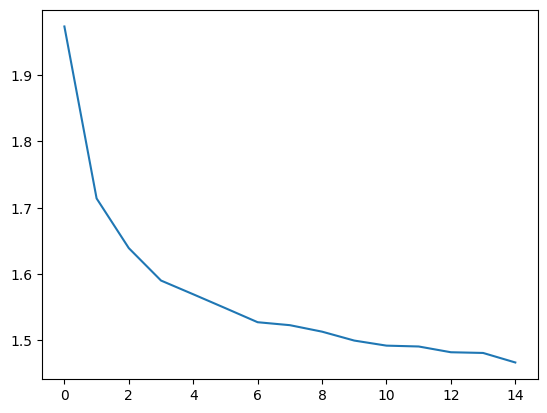

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PAD_IDX = 0

D_MODEL = 256
N_HEAD = 8
N_LAYER = 3          
D_FF = 512          
DROPOUT = 0.3        
MAX_LEN = 128
WARMUP_STEPS = 4000
N_EPOCHS = 15       

INPUT_DIM = src_tokenizer.get_vocab_size()
OUTPUT_DIM = trg_tokenizer.get_vocab_size()

model = Transformer(INPUT_DIM, OUTPUT_DIM, D_MODEL, N_HEAD, N_LAYER, D_FF, DROPOUT, MAX_LEN, PAD_IDX).to(DEVICE)

def init_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)
model.apply(init_weights)

print(f"Params (Safe Mode): {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9)
scheduler = NoamScheduler(optimizer, D_MODEL, WARMUP_STEPS)
criterion = LabelSmoothingLoss(OUTPUT_DIM, PAD_IDX, smoothing=0.1)

def train_epoch(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        trg_in = trg[:, :-1]
        trg_out = trg[:, 1:]
        optimizer.zero_grad()
        output = model(src, trg_in)
        output = output.contiguous().view(-1, output.shape[-1])
        trg_out = trg_out.contiguous().view(-1)
        loss = criterion(output, trg_out)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

best_loss = float('inf')
losses = []

print("Training Safe Mode...")
for epoch in range(N_EPOCHS):
    start = time.time()
    loss = train_epoch(model, train_iterator, optimizer, criterion, 1.0)
    end = time.time()
    losses.append(loss)
    print(f"Epoch {epoch+1:02} | Time: {(end-start)/60:.1f}m | Loss: {loss:.4f}")
    
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), os.path.join(CHECKPOINT_PATH, 'transformer_safe_best.pt'))

plt.plot(losses)
plt.savefig(os.path.join(PROJECT_PATH, 'loss_safe.png'))
plt.show()

# Inference+Evaluate

In [10]:
import sacrebleu
from tqdm import tqdm
import math
import urllib.request 
import tarfile

print("Loading Best Model...")
best_model_path = os.path.join(CHECKPOINT_PATH, 'transformer_safe_best.pt')
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
    print("Model loaded!")
else:
    print("WARNING: Không tìm thấy model checkpoint, đang dùng weight hiện tại.")

model.eval()

def beam_search_decode(sentence, model, device, beam_size=3, max_len=100):
    model.eval()
    src_ids = src_tokenizer.encode(sentence).ids
    src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encode(src_tensor, src_mask)
        beam = [([1], 0.0)] # SOS_IDX = 1
        
        for i in range(max_len):
            candidates = []
            all_ended = True
            for seq, score in beam:
                if seq[-1] == 2: # EOS_IDX = 2
                    candidates.append((seq, score))
                    continue
                all_ended = False
                trg_tensor = torch.LongTensor(seq).unsqueeze(0).to(device)
                trg_mask = model.make_trg_mask(trg_tensor)
                output = model.decode(trg_tensor, enc_src, trg_mask, src_mask)
                prob = output[:, -1, :]
                log_prob = torch.log_softmax(prob, dim=1).squeeze(0)
                topk_prob, topk_idx = torch.topk(log_prob, beam_size)
                for j in range(beam_size):
                    token = topk_idx[j].item()
                    p = topk_prob[j].item()
                    candidates.append((seq + [token], score + p))
            
            if all_ended: break
            beam = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_size]
            
    best_seq = beam[0][0]
    return trg_tokenizer.decode(best_seq, skip_special_tokens=True)

test_dir = os.path.join(PROJECT_PATH, 'test_data')
if not os.path.exists(test_dir): os.makedirs(test_dir)
tgz_path = os.path.join(test_dir, 'test.tgz')

if not os.path.exists(tgz_path) or os.path.getsize(tgz_path) < 1000:
    print("Downloading Test Data...")
    url = "https://github.com/stefan-it/nmt-en-vi/raw/master/data/test-2013-en-vi.tgz"
    try:
        urllib.request.urlretrieve(url, tgz_path)
        print("Download thành công!")
    except Exception as e:
        print(f"LỖI TẢI FILE: {e}")
        print("Vui lòng kiểm tra lại kết nối Internet của Kaggle (Settings -> Internet -> On)")
        raise e

if not os.path.exists(os.path.join(test_dir, 'tst2013.vi')):
    print("Extracting...")
    with tarfile.open(tgz_path, "r:gz") as tar: 
        tar.extractall(path=test_dir)

with open(os.path.join(test_dir, 'tst2013.vi'), 'r', encoding='utf-8') as f:
    src_sents = [html.unescape(line).replace('\xa0', ' ').strip() for line in f]
with open(os.path.join(test_dir, 'tst2013.en'), 'r', encoding='utf-8') as f:
    ref_sents = [html.unescape(line).replace('\xa0', ' ').strip() for line in f]

print(f"Evaluating Safe Mode with BEAM SEARCH (k=3)...")
hypotheses = []

for sent in tqdm(src_sents):
    pred = beam_search_decode(sent, model, DEVICE, beam_size=3)
    hypotheses.append(pred)

bleu = sacrebleu.corpus_bleu(hypotheses, [ref_sents], tokenize='13a')

print(f"\n{'='*40}")
print(f"SAFE MODE + BEAM SEARCH RESULT")
print(f"BLEU SCORE: {bleu.score:.2f}")
print(f"{'='*40}")

print("\n--- Examples ---")
for i in range(3):
    print(f"SRC : {src_sents[i]}")
    print(f"REF : {ref_sents[i]}")
    print(f"PRED: {hypotheses[i]}")
    print("-" * 20)

Loading Best Model...
Model loaded!


/tmp/ipykernel_55/2169181502.py:70: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=test_dir)


Download thành công!
Extracting...
Evaluating Safe Mode with BEAM SEARCH (k=3)...


100%|██████████| 1268/1268 [04:41<00:00,  4.50it/s]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



SAFE MODE + BEAM SEARCH RESULT
BLEU SCORE: 0.54

--- Examples ---
SRC : Khi tôi còn nhỏ , Tôi nghĩ rằng BắcTriều Tiên là đất nước tốt nhất trên thế giới và tôi thường hát bài " Chúng ta chẳng có gì phải ghen tị . "
REF : When I was little , I thought my country was the best on the planet , and I grew up singing a song called " Nothing To Envy . "
PRED: So I 'm going to show you a little bit about what I want to do .
--------------------
SRC : Tôi đã rất tự hào về đất nước tôi .
REF : And I was very proud .
PRED: So I 'm going to show you a little bit about what I want to do .
--------------------
SRC : Ở trường , chúng tôi dành rất nhiều thời gian để học về cuộc đời của chủ tịch Kim II- Sung , nhưng lại không học nhiều về thế giới bên ngoài , ngoại trừ việc Hoa Kỳ , Hàn Quốc và Nhật Bản là kẻ thù của chúng tôi .
REF : In school , we spent a lot of time studying the history of Kim Il-Sung , but we never learned much about the outside world , except that America , South Korea , Japan ar